In [1]:
%load_ext autoreload
%autoreload 2


In [6]:
import numpy as np
import clmm
import matplotlib.pyplot as plt
from data_functions import *
from model_functions import _delta_sigma_4theta, _delta_sigma_const, _delta_sigma_excess, gamma_tangential_monopole
from clmm import Cosmology
import scipy
from scipy.optimize import minimize

In [3]:
cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

r_proj = np.linspace(0.1,1.0,1000)
mdelta=10E14
cdelta=4.0
z_cl=0.3
sigma = clmm.compute_surface_density(r_proj, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)


In [4]:
q=2/3
ell = (1-q**2)/(1+q**2)
r_ = np.logspace(-1,1,100)*0.7

mdelta=2*1E14
delta_mdef = 200
cdelta=3.89
z_cl=0.8

rdelta = (mdelta/((4*np.pi/3)*cosmo.get_rho_m(z_cl)*delta_mdef))**(1/3)
rs=rdelta/cdelta

ds4theta, eta_func = _delta_sigma_4theta(ell, r_, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)
dsconst, eta_func = _delta_sigma_const(ell, r_, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)

In [7]:
g_t_monopole = gamma_tangential_monopole(r_proj, mdelta, cdelta, z_cl, cosmo, hpmd='nfw')

In [8]:
sigma_crit = 3.77988e+15

In [9]:
gamma1 = np.hstack(np.load("gamma1.npy") * -1)
gamma2 = np.hstack(np.load("gamma2.npy") * -1)

gammat = np.hstack(np.load("gamma_T.npy") * -1)
gammax = np.hstack(np.load("gamma_X.npy") * -1)


x_arcsec = np.hstack(np.load("x_arcsec.npy"))
y_arcsec = np.hstack(np.load("y_arcsec.npy"))


In [10]:
Nbins = 25
arcsec_to_Mpc = 0.00588784182755241
r, rbin_edges, r_bins, r_inds = make_radial_bins(x_arcsec*arcsec_to_Mpc, y_arcsec*arcsec_to_Mpc, Nbins)
theta = calc_theta(x_arcsec, y_arcsec)

delta_sigmas_4theta = []
delta_sigmas_const = []
delta_sigmas_4theta_cross = []
delta_sigmas_const_cross = []
for i in range(Nbins):
    select = (r_inds == i) #& (r>=0.1)
    theta_i = theta[select]
    gamma1_i = gamma1[select]
    gamma2_i = gamma2[select]
    w_i, w1_i, w2_i = weights(sigma_crit, theta_i)
    DS4thetai = Delta_Sigma_4theta(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_crit)
    DSconsti = Delta_Sigma_const(w_i, gamma1_i, sigma_crit)
    DS4thetacrossi = Delta_Sigma_4theta_cross(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_crit)
    DSconstcrossi = Delta_Sigma_const_cross(w_i, gamma2_i, sigma_crit)
    delta_sigmas_4theta.append([np.mean(DS4thetai), np.std(DS4thetai)/np.sqrt(len(DS4thetai))])
    delta_sigmas_const.append([np.mean(DSconsti), np.std(DSconsti)/np.sqrt(len(DSconsti))])
    delta_sigmas_4theta_cross.append([np.mean(DS4thetacrossi), np.std(DS4thetacrossi)/np.sqrt(len(DS4thetacrossi))])
    delta_sigmas_const_cross.append([np.mean(DSconstcrossi), np.std(DSconstcrossi)/np.sqrt(len(DSconstcrossi))])

/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

In [11]:
def MLE(B,x,y1,dy1, y2, dy2) :
    ## B = [ellipticity, log_mdelta, log_cdelta,]
    yPred1 = _delta_sigma_4theta(B[0], x, 10**B[1], 10**B[2], z_cl, cosmo=cosmo, hpmd='nfw', sample_N=1000)[0]
    s1 = dy1**2 + yPred1**2*np.exp(2*B[3])
    yPred2 = _delta_sigma_const(B[0], x, 10**B[1], 10**B[2], z_cl, cosmo=cosmo, hpmd='nfw', sample_N=1000)[0]
    s2 = dy2**2 + yPred2**2*np.exp(2*B[4])
    negLL = -np.sum(-(y1-yPred1)**2/2/s1 - np.log(2*np.pi*s1)/2) - np.sum(-(y2-yPred2)**2/2/s2 - np.log(2*np.pi*s2)/2)
    return negLL

In [12]:
order = np.isfinite(r_bins) & (r_bins >= rs)
results = minimize(MLE, [0,15,0, 0.1, 0.1], method='BFGS',
                   args=(r_bins[order], np.array(delta_sigmas_4theta)[:,0][order], np.array(delta_sigmas_4theta)[:,1][order],
                         np.array(delta_sigmas_const)[:,0][order], np.array(delta_sigmas_const)[:,1][order]), bounds=((0,1),(12,17),(0,1.5),(-10,0),(-10,0)))
results

/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 870.4372341030318
 hess_inv: array([[ 1.74294943e-04,  6.79800209e-04,  2.41592785e-03,
        -1.40806252e-01,  1.92866900e-03],
       [ 6.79800209e-04,  1.70175907e-02,  4.04938113e-02,
        -2.44733742e+00,  3.06123786e-02],
       [ 2.41592785e-03,  4.04938113e-02,  1.28360884e-01,
        -7.52351319e+00,  1.05601088e-01],
       [-1.40806252e-01, -2.44733742e+00, -7.52351319e+00,
         4.43430706e+02, -5.97278776e+00],
       [ 1.92866900e-03,  3.06123786e-02,  1.05601088e-01,
        -5.97278776e+00,  2.57737547e-01]])
      jac: array([-8.54492188e-04, -1.83868408e-03,  1.77001953e-03,  7.62939453e-06,
       -2.28881836e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 486
      nit: 38
     njev: 79
   status: 2
  success: False
        x: array([ 1.0227454 , 13.58989923,  0.45809423, -8.97993657, -0.68270962])

In [13]:
np.sqrt(np.diagonal(results.hess_inv))

array([1.32020810e-02, 1.30451488e-01, 3.58274872e-01, 2.10577944e+01,
       5.07678586e-01])

In [14]:
ds4theta, eta_func = _delta_sigma_4theta(results.x[0], r_, 10**results.x[1], 10**results.x[2], z_cl, cosmo, hpmd='nfw', sample_N=1000)
dsconst, eta_func = _delta_sigma_const(results.x[0], r_, 10**results.x[1], 10**results.x[2], z_cl, cosmo, hpmd='nfw', sample_N=1000)

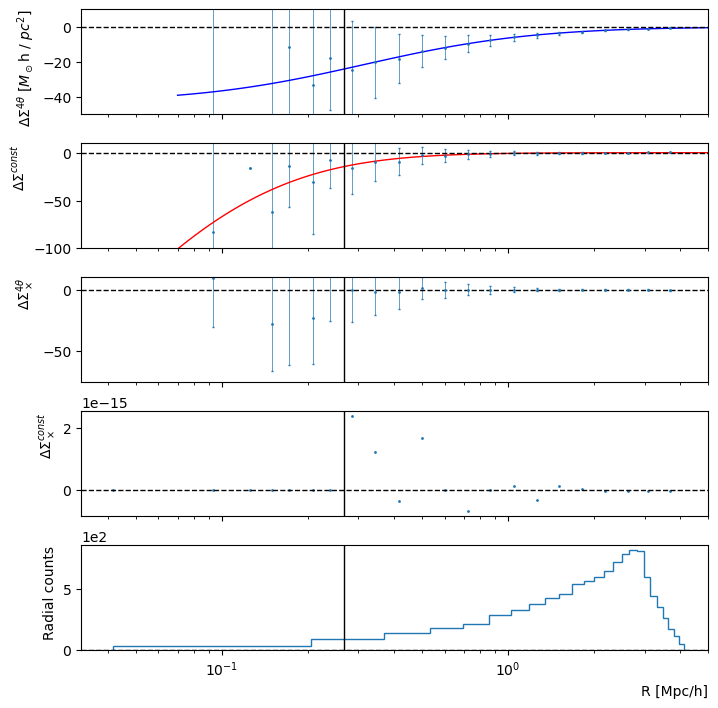

In [15]:
fig, axs = plt.subplots(5,1, figsize=(7,7), sharex=True);
plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,2))
plt.tight_layout();

## Delta Sigma 4theta
axs[0].errorbar(r_bins, np.array(delta_sigmas_4theta)[:,0] / 0.7 / 1e12, yerr=np.array(delta_sigmas_4theta)[:,1] / 0.7 / 1e12, fmt='o', markersize=1, ls='none', elinewidth=0.5, capsize=1);
axs[0].plot(r_, ds4theta/0.7 / 1e12, 'b-', lw=1);
axs[0].set_ylabel(r'$\Delta \Sigma^{4\theta}$ [$M_\odot$h / $pc^2$]', loc='top');
axs[0].set_xscale('log');
axs[0].set_ylim(-50, 10);
axs[0].axhline(0, lw=1, ls='--', c='k');
axs[0].axvline(rs, lw=1, ls='-', c='k');

## Delta Sigma const
axs[1].errorbar(r_bins, np.array(delta_sigmas_const)[:,0] / 0.7 / 1e12, yerr=np.array(delta_sigmas_const)[:,1] / 0.7 / 1e12, fmt='o', markersize=1, ls='none', elinewidth=0.5, capsize=1);
axs[1].plot(r_, dsconst/0.7 / 1e12, 'r-', lw=1)
axs[1].set_ylabel(r'$\Delta \Sigma^{const}$', loc='top');
axs[1].set_xscale('log');
axs[1].set_ylim(-100, 10);
axs[1].axhline(0, lw=1, ls='--', c='k');
axs[1].axvline(rs, lw=1, ls='-', c='k');

## Delta Sigma 4theta X
axs[2].errorbar(r_bins, np.array(delta_sigmas_4theta_cross)[:,0] / 0.7 / 1e12, yerr=np.array(delta_sigmas_4theta_cross)[:,1] / 0.7 / 1e12, fmt='o', markersize=1, ls='none', elinewidth=0.5, capsize=1);
axs[2].set_ylabel(r'$\Delta \Sigma^{4\theta}_\times$', loc='top');
axs[2].set_xscale('log');
axs[2].set_ylim(top=10);
axs[2].axhline(0, lw=1, ls='--', c='k');
axs[2].axvline(rs, lw=1, ls='-', c='k');

## Delta Sigma const X
axs[3].scatter(r_bins, np.array(delta_sigmas_const_cross)[:,0] / 0.7 / 1e12, s=1);
axs[3].set_ylabel(r'$\Delta \Sigma^{const}_\times$', loc='top');
axs[3].set_xscale('log');
axs[3].axhline(0, lw=1, ls='--', c='k');
axs[3].axvline(rs, lw=1, ls='-', c='k');

axs[4].hist(r, bins=Nbins, histtype='step');
axs[4].axhline(0, lw=1, ls='--', c='k');
axs[4].axvline(rs, lw=1, ls='-', c='k');
axs[4].set_ylabel('Radial counts', loc='top');
axs[4].set_xlabel('R [Mpc/h]', loc='right');
axs[4].set_xlim(right=5);

## Calculate monopole term

In [16]:
from scipy.stats import binned_statistic

In [17]:
gammat_mono = -2*binned_statistic(r, gamma1*np.cos(2*theta), statistic='mean', bins=rbin_edges)[0]

In [18]:
DS_model = _delta_sigma_excess(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000, delta_mdef=200)

In [19]:
eta_0_arr = np.gradient(np.log(DS_model),r)*r


/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


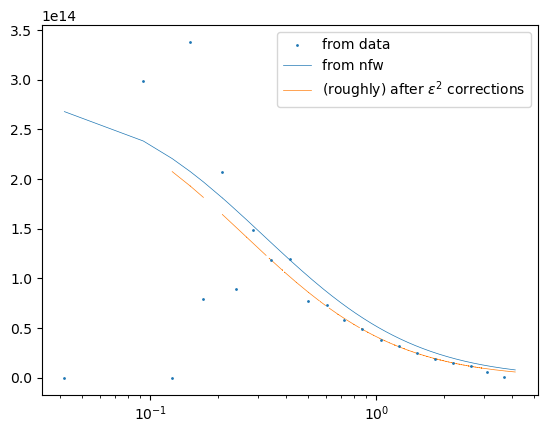

In [20]:
r_order = np.argsort(r)
plt.scatter(r_bins, gammat_mono*sigma_crit, s=1, label='from data', zorder=np.inf);
plt.plot(r[r_order], DS_model[r_order], lw=0.5, label='from nfw');
plt.plot(r[r_order], DS_model[r_order]/q**(eta_0_arr[r_order]/2), lw=0.5, label='(roughly) after $\epsilon^2$ corrections');
plt.xscale('log');
plt.legend();

## Implementing emcee

In [21]:
def log_prior(theta):
    ell_, log_mdelta, cdelta, log_f1, log_f2 = theta
    if (0 <= ell <= 1) and (12 <= log_mdelta <= 18) and (0 <= cdelta <= 1.5) and (-10 <= log_f1 <= 0) and (-10 <= log_f2 <= 0) :
        return 0.0
    return -np.inf

In [22]:
def log_probability(theta, x, y1, dy1, y2, dy2) :
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + MLE(theta, x, y1, dy1, y2, dy2)

In [23]:
pos = np.array([[np.random.random(), 12+(18-12)*np.random.random(), 1.5*np.random.random(), -10 + (0-10)*np.random.random(), -10 + (0-10)*np.random.random()] for _ in range(32)])
pos

array([[ 3.75368275e-01,  1.20990569e+01,  8.02084922e-01,
        -1.99628266e+01, -1.17109306e+01],
       [ 9.98027780e-01,  1.51264329e+01,  6.69307847e-01,
        -1.86886503e+01, -1.38087868e+01],
       [ 9.24733050e-01,  1.47363801e+01,  4.50804033e-01,
        -1.06378926e+01, -1.49130001e+01],
       [ 4.13033368e-01,  1.40389098e+01,  1.14347961e+00,
        -1.96410239e+01, -1.26302757e+01],
       [ 8.25670800e-01,  1.32157415e+01,  5.73978299e-01,
        -1.72432633e+01, -1.75011207e+01],
       [ 9.13270815e-01,  1.67629704e+01,  1.26709139e+00,
        -1.74666477e+01, -1.84776543e+01],
       [ 7.36228868e-01,  1.59115107e+01,  1.31286107e+00,
        -1.35156557e+01, -1.78171422e+01],
       [ 5.20619598e-01,  1.71875491e+01,  1.13265210e+00,
        -1.81106753e+01, -1.90077907e+01],
       [ 7.43343613e-01,  1.58547058e+01,  1.77819839e-02,
        -1.57861251e+01, -1.93318050e+01],
       [ 9.92999055e-01,  1.78690945e+01,  8.49909677e-01,
        -1.94290777e+01

In [24]:
results.x + 1e-4*np.random.randn(32,5)

array([[ 1.02283573, 13.58984602,  0.4580085 , -8.98003754, -0.68261987],
       [ 1.02271737, 13.58983485,  0.45806703, -8.97989421, -0.68274471],
       [ 1.02279808, 13.58997142,  0.45822089, -8.97982913, -0.68273053],
       [ 1.02266369, 13.58990758,  0.45805186, -8.9797951 , -0.68257737],
       [ 1.02260348, 13.58989496,  0.45805835, -8.98016964, -0.68268082],
       [ 1.02295238, 13.58976647,  0.45830578, -8.98001081, -0.68261532],
       [ 1.0227304 , 13.58989615,  0.45792892, -8.97980217, -0.68264639],
       [ 1.02274858, 13.58980605,  0.45813102, -8.97986529, -0.68263352],
       [ 1.02277898, 13.58987315,  0.45816466, -8.97991005, -0.682993  ],
       [ 1.02280431, 13.58986218,  0.45822908, -8.98005695, -0.68264549],
       [ 1.02281722, 13.58998075,  0.45806382, -8.98007655, -0.6828059 ],
       [ 1.02273649, 13.58987554,  0.45817476, -8.97986102, -0.68256024],
       [ 1.02274001, 13.58995726,  0.45823037, -8.97986203, -0.68260282],
       [ 1.02268665, 13.58992842,  0.4

In [25]:
import emcee

# pos = np.array([np.random.random(), 12+(18-12)*np.random.random(), 1.5*np.random.random(), -10 + (0-10)*np.random.random(), -10 + (0-10)*np.random.random()])
# pos = results.x + 1e-4 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(r_bins[order], np.array(delta_sigmas_4theta)[:,0][order], np.array(delta_sigmas_4theta)[:,1][order], np.array(delta_sigmas_const)[:,0][order], np.array(delta_sigmas_const)[:,1][order]))
sampler.run_mcmc(pos, 10000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:07<00:00, 1390.91it/s]


In [26]:
tau = sampler.get_autocorr_time()
print(tau)

/sps/lsst/users/rsolomon/conda_envs/desc_dev/lib/python3.10/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


[nan nan nan nan nan]


In [27]:
flat_samples = np.concatenate(sampler.chain[:, 150:,:])
print(flat_samples.shape)

(315200, 5)


In [28]:
from IPython.display import display, Math

labels = ['\epsilon', '\log M_\Delta', '\log c_\Delta', '\log f_1', '\log f_2']
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [29]:
import corner

SystemError: initialization of _internal failed without raising an exception

In [ ]:
fig = corner.corner(flat_samples);